# Final Exercice: The Rumos Bank 

The Rumos Bank é um banco que tem perdido bastante dinheiro devido à quantidade de créditos que fornece e que não são pagos dentro do prazo devido. 

    - Por cada cliente que se estima que não irá  pagar dentro do prazo e afinal paga, o banco tem um custo de 1000euros. 

    - Por cada cliente que se prevê como sendo um bom pagador e afinal não paga dentro do prazo, o banco tem um custo de 3000euros.


Vocês, data scientists de topo,  são contratados para ajudar o banco a prever quais os clientes que não irão cumprir os prazos, para que este consiga uma melhor gestão dos fundos.

Conseguem construir um modelo que ajude a detectar previamente e com sucesso os clientes que são maus pagadores?


Dataset: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

Variáveis disponíveis:

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
    PAY_2: Repayment status in August, 2005 (scale same as above)
    PAY_3: Repayment status in July, 2005 (scale same as above)
    PAY_4: Repayment status in June, 2005 (scale same as above)
    PAY_5: Repayment status in May, 2005 (scale same as above)
    PAY_6: Repayment status in April, 2005 (scale same as above)
    BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    default.payment.next.month: Default payment (1=yes, 0=no)

#### Perguntas:

    1. Quantas features estão disponíveis? Quantos clientes?
    2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?
    3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?
    4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?
    5. Qual seria o custo que o banco tem sem nenhum modelo?
    6. Qual o custo que o banco passa a tar com o vosso modelo?

Com base na informação dada, podemos definir que:

    True positive - Os maus pagadores são identificados correctamente.
    True negative - Os bons pagadores são identificados correctamente.
    False positive - Um bom pagador é identificado como sendo um mau pagador.
    False negative - Um mau pagador é identificado como sendo um bom pagador.

In [6]:
root_path = '../data/'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,auc,
    roc_curve
)

# Importar o mlflow
import mlflow
from mlflow.models import infer_signature

import json

In [8]:
# Tornar a amostra reproduzível
SEED = 42

# Tamanho do dataset de testes 
TEST_SIZE = 0.2

# Coluna Target
TARGET_COLUMN = "default.payment.next.month"

#### Definir a diretoria onde as experiências são guardadas

In [9]:
from pathlib import Path

# uri = "../mlruns"
#Path(uri).mkdir(parents=True, exist_ok=True)
#uri = "http://0.0.0.0:5000"
uri = "http://localhost:5000"

mlflow.set_tracking_uri(uri)



#### Fazer set da experiência "Bank Rumos - Prever clientes maus pagadores"

In [10]:
mlflow.set_experiment("Bank Rumos - Classificação de clientes maus pagadores")

2025/03/22 21:55:47 INFO mlflow.tracking.fluent: Experiment with name 'Bank Rumos - Classificação de clientes maus pagadores' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/979435372240062290', creation_time=1742680547178, experiment_id='979435372240062290', last_update_time=1742680547178, lifecycle_stage='active', name='Bank Rumos - Classificação de clientes maus pagadores', tags={}>

#### Ler o ficheiro CSV e carregá-lo no dataframe

In [11]:
file_path = root_path + 'lending_data.csv'
df = pd.read_csv(file_path)

In [12]:
df.shape

(30000, 25)

In [13]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [14]:
df.ID.nunique()

30000

#### 1. Quantas features estão disponíveis? Quantos clientes?

    - Existem 24 features disponíveis no dataset.
    - Existem 30000 clientes.

Existem missing values?

In [15]:
df.isnull().values.any()

np.False_

Existem o mesmo número de clientes nas duas classes?

In [16]:
df.groupby(TARGET_COLUMN)[TARGET_COLUMN].count()

default.payment.next.month
0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Não! O dataset é altamente desequilibrado.

#### 2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?

    - 23,364 foram bons pagadores. 6,636 foram maus pagadores.

Existem features não númericas?

In [17]:
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

Todas as features são númericas.

Vamos retirar o ID do cliente:

In [18]:
df = df.drop('ID', axis = 1)

Vamos então dividir o dataset em treino e teste:

In [19]:
train_set, test_set = train_test_split(df, test_size = TEST_SIZE, random_state = SEED)

# Utilizar apenas 20% dos dados treino
train_set = train_set.sample(frac=0.05, random_state = SEED)

In [20]:
X_train = train_set.drop([TARGET_COLUMN], axis = 'columns')
y_train = train_set[TARGET_COLUMN]

X_test = test_set.drop([TARGET_COLUMN], axis = 1)
y_test = test_set[TARGET_COLUMN]

A normalização passou a integrar o pipeline de cada um dos modelos

In [21]:
scaler = MinMaxScaler()

features_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = features_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features_names)

Antes de iniciar, vamos calcular a baseline, ou seja, o custo que temos sem nenhum modelo.

$$totalCost = 1000∗FP+3000∗FN$$

In [22]:
y_preds_all_bad = np.ones(y_test.shape) 

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 0
Number of True Positives: 1313
Number of False Negatives: 0
Number of False Positives: 4687


In [24]:
print('Total Cost:', fp*1000)

Total Cost: 4687000


In [25]:
accuracy_score(y_test, y_preds_all_bad)

0.21883333333333332

Se todos os clientes fossem considerados como maus pagadores, o banco teria um custo de 4,687,000 Euros.

In [26]:
y_preds_all_good = np.zeros(y_test.shape) 

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 4687
Number of True Positives: 0
Number of False Negatives: 1313
Number of False Positives: 0


In [27]:
print('Total Cost:', fn*3000)

Total Cost: 3939000


In [28]:
accuracy_score(y_test, y_preds_all_good)

0.7811666666666667

Se todos os clientes fossem considerados bons pagadores, o banco teria um custo de 3,939,000 Euros.

In [29]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000
    
    return cost_fn + cost_fp
    

In [30]:
def min_cost_threshold(y_test, y_preds):
    
    costs = {}
    
    for threshold in np.arange(0, 1.1, 0.1):
        
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold = threshold)
        
    plt.plot(list(costs.keys()), list(costs.values()))
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.show()
    

In [31]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state=SEED),
        "params": {"model__C": [0.01, 0.1, 1, 10]}
    },
    "SVM": {
        "model": SVC(random_state=SEED),
        "params": {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=SEED),
        "params": {"model__n_estimators": [50, 100, 200]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"model__n_neighbors": [3, 5, 7, 9]}
    }
}

In [32]:
# # Criar experiência no MLflow
# mlflow.set_experiment("Rumos Bank - GridSearch Model Comparison")

# with mlflow.start_run(run_name="Configuraçõs Globais") as parent_run:
#     # Guardar configurações globais:
#     # Dataset 
#     full_dataset = mlflow.data.from_pandas(df, source=file_path, targets=TARGET_COLUMN, name="Full Dataset")
#     mlflow.log_input(full_dataset, context="full")

#     # Registar os parâmetros do split
#     mlflow.log_param("test_size", TEST_SIZE)

#     # Guardar a seed utilizado como parametro
#     mlflow.log_param("seed", SEED)

#     # Registar os tamanhos dos conjuntos
#     mlflow.log_param("train_samples", len(X_train))
#     mlflow.log_param("test_samples", len(X_test))
   
#     # Loop para treinar e avaliar cada um dos modelos     
#     for name, clf, params in models:        
    
#         with mlflow.start_run(run_name=name):  # Criar um run para cada modelo
        
#             # Criar pipeline com normalização (para modelos que precisam)
#             # pipeline = Pipeline([
#             #     ("scaler", StandardScaler()),  
#             #     ("model", model_info["model"])
#             # ])
        
#             # Aplicar GridSearchCV
#             grid_search = GridSearchCV(clf, params, cv = 5).fit(X_train, y_train)
            
#             # Melhor modelo encontrado
#             best_model = grid_search.best_estimator_
#             best_params = grid_search.best_params_
            
#             # Previsões e avaliação
#             y_pred = best_model.predict(X_test)
#             accuracy = accuracy_score(y_test, y_pred)

#             # Registar tudo no MLflow
#             mlflow.log_params(best_params)  # Salva os melhores hiperparâmetros
#             mlflow.log_metric("accuracy", accuracy)  # Salva a métrica de acurácia
#             mlflow.sklearn.log_model(best_model, name)  # Guardar o modelo treinado
            

#### Fazer set da experiência "Rumos Bank - Comparação de modelos"

In [33]:
# Criar experiência no MLflow
mlflow.set_experiment("Rumos Bank - Comparação de modelos")

2025/03/22 21:55:48 INFO mlflow.tracking.fluent: Experiment with name 'Rumos Bank - Comparação de modelos' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/625657914822177401', creation_time=1742680548835, experiment_id='625657914822177401', last_update_time=1742680548835, lifecycle_stage='active', name='Rumos Bank - Comparação de modelos', tags={}>

#### Criar um run principal com configurações globais do dataset

In [34]:
# Guardar configurações globais:
mlflow.start_run(run_name="Configuraçõs Globais")

# Dataset 
full_dataset = mlflow.data.from_pandas(df, source=file_path, targets=TARGET_COLUMN, name="Full Dataset")
mlflow.log_input(full_dataset, context="full")

# Registar os parâmetros do split
mlflow.log_param("test_size", TEST_SIZE)

# Guardar a seed utilizado como parametro
mlflow.log_param("seed", SEED)

# Registar os tamanhos dos conjuntos
mlflow.log_param("train_samples", len(X_train))
mlflow.log_param("test_samples", len(X_test))
   
# Definir o formato esperado das entradas e saídas do modelo.
signature = infer_signature(X_train, y_train)

c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/lending_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcemen

### Logistic Regression

#### Criar uma run - Regressão Logística

In [35]:
run = mlflow.start_run(run_name="Regressão Logistica", nested=True)
RUN_ID = run.info.run_uuid
RUN_ID

'f56379aca958442f80a92dffe47cdb17'

#### Guardar modelos, artefactos, métricas e parametros da run

In [36]:
%%time

# Criar pipeline com normalização
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logistic_regression", LogisticRegression(max_iter = 500, solver = 'lbfgs', random_state = SEED, class_weight = 'balanced'))
    ]
)
parameters = {'logistic_regression__C':[0.001, 0.01, 0.1, 1, 10, 100]}

# Aplicar GridSearchCV
clf_lr = GridSearchCV(pipeline, parameters , cv=5).fit(X_train, y_train)

#mlflow.sklearn.log_model(lr_pipeline, artifact_path="lr_pipeline", registered_model_name="logistic_reg")
pipeline


CPU times: total: 1.3 s
Wall time: 1.22 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

In [37]:
mlflow.set_tag("model_name", "Regressão Logistica")

params = pipeline.get_params()

modified_params = {}
for k, v in params.items():
    new_key = k.replace("logistic_regression__", '')
    modified_params[new_key] = v

mlflow.log_params(modified_params)
modified_params

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('logistic_regression',
   LogisticRegression(class_weight='balanced', max_iter=500, random_state=42))],
 'transform_input': None,
 'verbose': 0,
 'scaler': StandardScaler(),
 'logistic_regression': LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'warm_start': False}

In [38]:
# Registar hiperparâmetros
mlflow.log_param("max_iter", 500)
mlflow.log_param("solver", "lbfgs")
mlflow.log_param("random_state", SEED)
mlflow.log_param("class_weight", "balanced")

# Melhor modelo encontrado
best_model = clf_lr.best_estimator_

# Registar o modelo
mlflow.sklearn.log_model(best_model, artifact_path="logistic_regression", registered_model_name="logistic_regression", signature=signature)


Successfully registered model 'logistic_regression'.
2025/03/22 21:56:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_regression, version 1
Created version '1' of model 'logistic_regression'.


In [39]:
# Registar métricas do melhor modelo
mlflow.log_metric("best_cv_score", clf_lr.best_score_)

score = clf_lr.score(X_test, y_test) #########
mlflow.log_metric("score", score)

score

0.6526666666666666

In [40]:
y_preds = clf_lr.predict_proba(X_test)[:,1]

# Converter previsões para JSON
predictions_json = json.dumps(y_preds.tolist())

# Guardar como artefato de texto
with open("predictions.json", "w") as f:
    f.write(predictions_json)

mlflow.log_artifact("predictions.json")
 
y_preds


array([0.51323015, 0.48340774, 0.50961728, ..., 0.52235378, 0.49011353,
       0.45865327], shape=(6000,))

In [41]:
cost = total_cost(y_test, y_preds, threshold=0.5)

mlflow.log_metric("total_cost", cost)   ###################

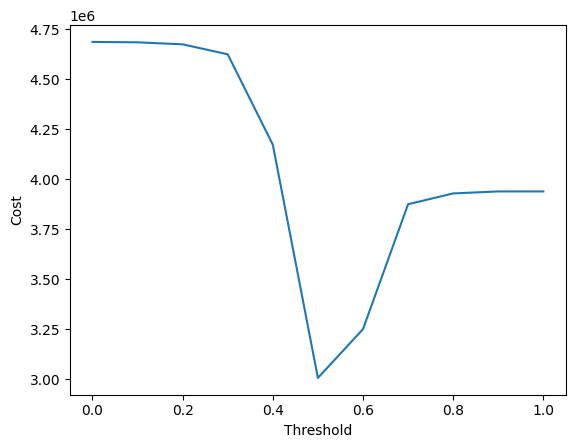

In [42]:
min_cost_threshold(y_test, y_preds)

In [43]:
cost = total_cost(y_test, y_preds, threshold = 0.6)

mlflow.log_metric("total_cost", cost)

#### Terminar a run

In [44]:
mlflow.end_run()

🏃 View run Regressão Logistica at: http://localhost:5000/#/experiments/625657914822177401/runs/f56379aca958442f80a92dffe47cdb17
🧪 View experiment at: http://localhost:5000/#/experiments/625657914822177401


O Custo é minimo para um threshold de 0.6: 2,646,000 Euros, que é a melhor que a baseline!

### KNN

#### Criar uma run - KNN

In [45]:
run = mlflow.start_run(run_name="KNN", nested=True)
RUN_ID = run.info.run_uuid
RUN_ID

'd2678680cf3941c8b2e0ac61ab2ab565'

#### Guardar datasets, modelos, artefactos, métricas e parametros da run

In [46]:
%%time
knn = KNeighborsClassifier()

parameters = {'n_neighbors': range(1,10, 1)}

clf_knn = GridSearchCV(knn, parameters, cv = 5).fit(X_train, y_train)

mlflow.log_param("n_neighbors_min", 1)
mlflow.log_param("n_neighbors_max", 10)
mlflow.log_param("n_neighbors_step", 1)
mlflow.log_param("cv", 5)

mlflow.log_param("grid_search", str(parameters))

# Melhor pontuação de validação
mlflow.log_metric("best_score", clf_knn.best_score_)

# Melhor parâmetro n_neighbors
mlflow.log_param("best_n_neighbors", clf_knn.best_params_["n_neighbors"])

# Registar o modelo
mlflow.sklearn.log_model(best_model, artifact_path="knn_model", registered_model_name="knn_model", signature=signature)


Successfully registered model 'knn_model'.
2025/03/22 21:56:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: knn_model, version 1


CPU times: total: 8.69 s
Wall time: 12.3 s


Created version '1' of model 'knn_model'.


KNN não é um metodo adequado para grandes datasets! Vamos ver se compensa a nível de resultados:

In [47]:
y_preds = clf_knn.predict_proba(X_test)[:,1]

# Converter previsões para JSON
predictions_json = json.dumps(y_preds.tolist())

# Guardar como artefato de texto
with open("predictions.json", "w") as f:
    f.write(predictions_json)

mlflow.log_artifact("predictions.json")

clf_knn.score(X_test, y_test)

0.7968333333333333

In [48]:
cost = total_cost(y_test, y_preds, threshold=0.5)

mlflow.log_metric("total_cost", cost)

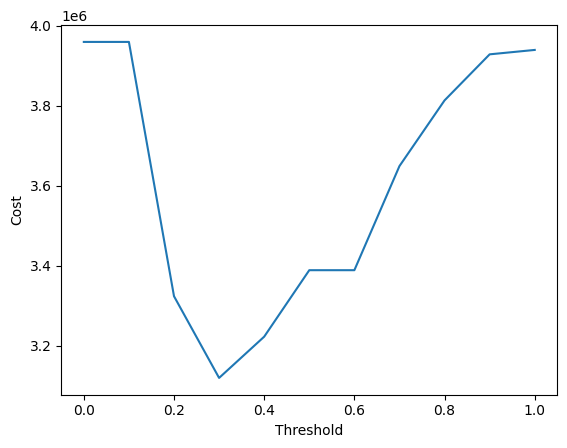

In [49]:
min_cost_threshold(y_test, y_preds)

In [50]:
cost = total_cost(y_test, y_preds, threshold = 0.3)
           
mlflow.log_metric("total_cost", cost)    

#### Terminar a run

In [51]:
mlflow.end_run()

🏃 View run KNN at: http://localhost:5000/#/experiments/625657914822177401/runs/d2678680cf3941c8b2e0ac61ab2ab565
🧪 View experiment at: http://localhost:5000/#/experiments/625657914822177401


Melhor que a baseline mas pior que usar regressão logistica.

### SVM

#### Criar uma run - SVM

In [52]:
run = mlflow.start_run(run_name="SVM", nested=True)
RUN_ID = run.info.run_uuid
RUN_ID

'da6141c2751c43159afb274c58e247f2'

In [53]:
%%time

svc = SVC(random_state = SEED, class_weight = 'balanced', gamma = 'scale', probability = True, verbose = True)

parameters = {'C':[0.1, 1, 10], 'kernel': ('rbf', 'linear') }

clf_svc = GridSearchCV(svc, parameters, cv = 5).fit(X_train, y_train)

[LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]CPU times: total: 12.1 s
Wall time: 13.1 s


In [54]:
y_preds = clf_svc.predict_proba(X_test)[:,1]

In [55]:
clf_svc.score(X_test, y_test)

0.7603333333333333

In [56]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(3457000)

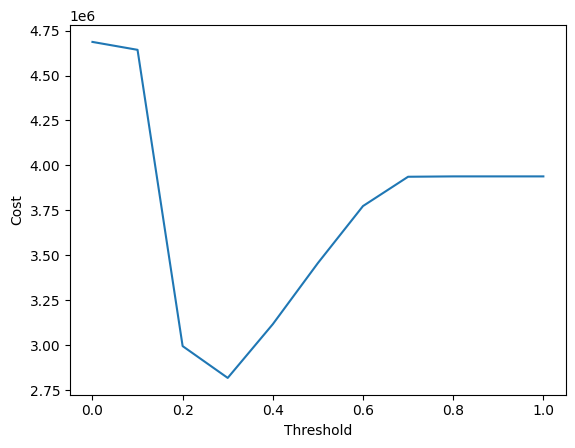

In [57]:
min_cost_threshold(y_test, y_preds)

In [58]:
total_cost(y_test, y_preds, threshold = 0.3)

np.int64(2818000)

#### Terminar a run

In [59]:
mlflow.end_run()

🏃 View run SVM at: http://localhost:5000/#/experiments/625657914822177401/runs/da6141c2751c43159afb274c58e247f2
🧪 View experiment at: http://localhost:5000/#/experiments/625657914822177401


Melhor valor até agora!

### Decision Trees

#### Criar uma run - Decision Trees

In [60]:
run = mlflow.start_run(run_name="Decision Trees", nested=True)
RUN_ID = run.info.run_uuid
RUN_ID

'c95b2aaa8ea040aab42384550f5e1686'

In [61]:
%%time

trees = tree.DecisionTreeClassifier(random_state = SEED,  class_weight = 'balanced')

parameters = {'max_depth':[3, 6], 'min_samples_split': [2, 4, 10]}

clf_tree = GridSearchCV(trees, parameters, cv = 5).fit(X_train, y_train)

CPU times: total: 562 ms
Wall time: 576 ms


In [62]:
clf_tree.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)

In [63]:
y_preds = clf_tree.predict_proba(X_test)[:,1]

clf_tree.score(X_test, y_test)

0.6373333333333333

In [64]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(3078000)

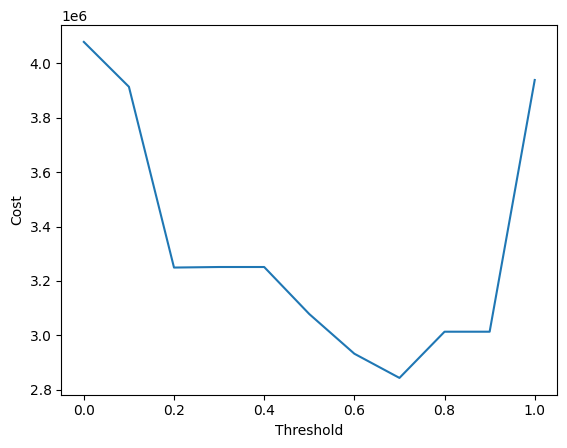

In [65]:
min_cost_threshold(y_test, y_preds)

In [66]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(3078000)

#### Terminar a run

In [67]:
mlflow.end_run()

🏃 View run Decision Trees at: http://localhost:5000/#/experiments/625657914822177401/runs/c95b2aaa8ea040aab42384550f5e1686
🧪 View experiment at: http://localhost:5000/#/experiments/625657914822177401


SVMs continuam a ganhar.

### Random Forests

#### Criar uma run - Random Forests

In [68]:
run = mlflow.start_run(run_name="Random Forests", nested=True)
RUN_ID = run.info.run_uuid
RUN_ID

'c55b201560f446a5b455198cafdcc874'

In [69]:
%%time 
rf = RandomForestClassifier(random_state = SEED,  class_weight = 'balanced').fit(X_train, y_train)

parameters = {'n_estimators':[10, 100, 300, 1000]}

clf_rf = GridSearchCV(rf, parameters, cv = 5).fit(X_train, y_train)

CPU times: total: 36.5 s
Wall time: 37.4 s


In [70]:
y_preds = clf_rf.predict_proba(X_test)[:,1]

clf_rf.score(X_test, y_test)

0.8021666666666667

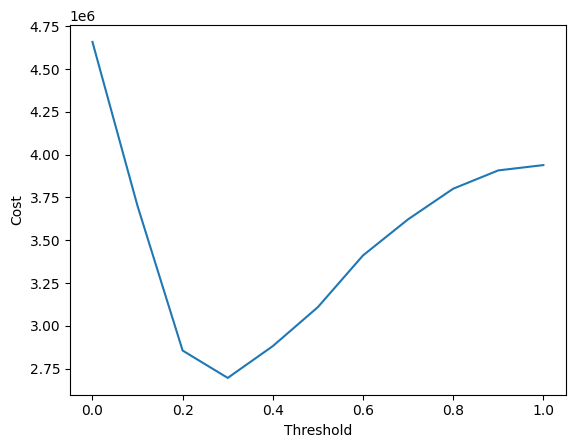

In [71]:
min_cost_threshold(y_test, y_preds)

In [72]:
total_cost(y_test, y_preds, threshold = 0.3)

np.int64(2695000)

#### Terminar a run

In [73]:
mlflow.end_run()

🏃 View run Random Forests at: http://localhost:5000/#/experiments/625657914822177401/runs/c55b201560f446a5b455198cafdcc874
🧪 View experiment at: http://localhost:5000/#/experiments/625657914822177401


Melhor resultado até agora!

### Neural Networks

#### Criar uma run - Neural Networks

In [74]:
run = mlflow.start_run(run_name="Decision Trees", nested=True)
RUN_ID = run.info.run_uuid
RUN_ID

'252a3dcb0b4a4c4e84a539cb138c328f'

In [75]:
X_train.shape

(1200, 23)

In [76]:
%%time

mlp = MLPClassifier(solver = 'lbfgs',  random_state = SEED, max_iter = 1000 )

parameters = {'hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

clf_mlp = GridSearchCV(mlp, parameters, cv = 5).fit(X_train, y_train)

c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546

CPU times: total: 1min 48s
Wall time: 1min 53s


c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [77]:
clf_mlp.best_estimator_

MLPClassifier(hidden_layer_sizes=(20,), learning_rate_init=0.0001,
              max_iter=1000, random_state=42, solver='lbfgs')

In [78]:
clf_mlp.best_score_

np.float64(0.7283333333333334)

In [79]:
y_preds = clf_mlp.predict_proba(X_test)[:,1]

clf_mlp.score(X_test, y_test)


0.7636666666666667

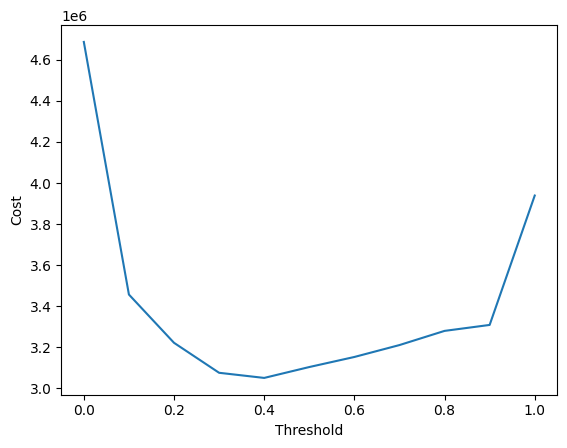

In [80]:
min_cost_threshold(y_test, y_preds)

In [81]:
total_cost(y_test, y_preds, threshold = 0.2)

np.int64(3222000)

#### Terminar a run

In [82]:
mlflow.end_run()


🏃 View run Decision Trees at: http://localhost:5000/#/experiments/625657914822177401/runs/252a3dcb0b4a4c4e84a539cb138c328f
🧪 View experiment at: http://localhost:5000/#/experiments/625657914822177401


In [83]:
# Fechar o run pincipal
mlflow.end_run()

🏃 View run Configuraçõs Globais at: http://localhost:5000/#/experiments/625657914822177401/runs/659900ae67bc4172861efb5ec6c2724f
🧪 View experiment at: http://localhost:5000/#/experiments/625657914822177401


Resultado quase igual às random forests!

#### 3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?

- A métrica usada foi o custo total uma vez que o objetivo do modelo era diminuir os custos do banco. O Modelo que levou a melhores resultados foram as neural networks e as random forests - 2,467,000 de custo.  
- Visto que com as neural networks não consigo saber qual a importancia das features, vou eleger o modelo de random forests como a solução final. Para além disso o treino das neural networks demorou quase o dobro do tempo.

#### 4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?

In [84]:
rf = RandomForestClassifier(**clf_rf.best_params_).fit(X_train, y_train)

In [85]:
important_features = pd.DataFrame(data = rf.feature_importances_, index = X_train.columns, columns = ['value'])
important_features.sort_values(by = 'value', ascending = False)

,value
PAY_0,0.065482
AGE,0.064376
BILL_AMT1,0.063213
LIMIT_BAL,0.058743
PAY_AMT1,0.053872
BILL_AMT3,0.053729
BILL_AMT2,0.053132
PAY_AMT2,0.052983
BILL_AMT4,0.051547
PAY_AMT3,0.051234


As variaveis que mais contribuem para o modelo decidir se um cliente vai ser um bom ou mau pagador são:
    - PAY_0 - Repayment status in September, 2005 
    - e AGE - idade do cliente
    

#### 5. Qual seria o custo que o banco tem sem nenhum modelo?

    - O custo que o banco teria sem modelo, ou seja, assumindo que todos os clientes seriam bons pagadores, é de: 3,939,000 Euros.

#### 6. Qual o custo que o banco passa a tar com o vosso modelo?

- O custo que o banco teria com o modelo seria de: 2,476,000 Euros - Pouparia quase 1 Milhão e meio de Euros!